## IMPORT NEEDED LIBRARY

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import json
import itertools
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## LABELING DATA

{'apple': 2000, 'bowtie': 2000, 'circle': 2000, 'cloud': 2000, 'cup': 2000, 'diamond': 2000, 'fish': 2000, 'guitar': 2000, 'hat': 2000, 'headphones': 2000, 'ladder': 2000, 'laptop': 2000, 'leaf': 2000, 'moon': 2000, 'pants': 2000, 'pencil': 2000, 'rectangle': 2000, 'soccer_ball': 2000, 'sock': 2000, 'star': 2000, 'sun': 2000, 't-shirt': 2000, 'triangle': 2000, 'watermelon': 2000, 'wine glass': 2000}


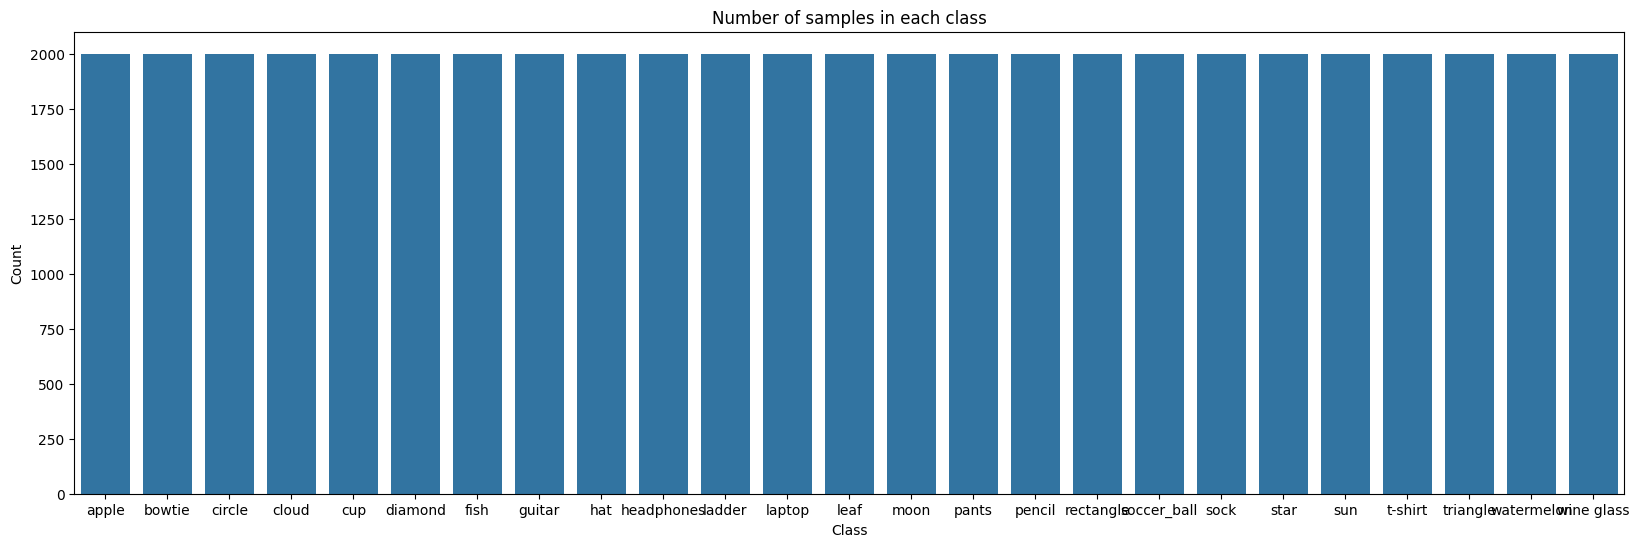

In [27]:
path = "augmented_data3"
counts = {}
folders = os.listdir(path)
for folder in folders:
    count = len(os.listdir(os.path.join(path, folder)))
    if folder not in counts:
        counts[folder] = count
print(counts)

fig, ax = plt.subplots(figsize = (20, 6))
sns.barplot(counts, ax=ax)
plt.title("Number of samples in each class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

(64, 64, 3)


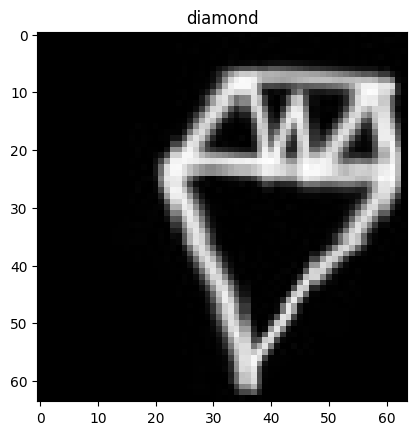

In [28]:
random_class = random.choice(folders)
new_path = os.path.join(path, random_class)
random_sample = random.choice(os.listdir(new_path))
img_path = os.path.join(new_path, random_sample)
img = Image.open(img_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img)
plt.title(random_class)
plt.show()

In [29]:
classes = sorted(os.listdir(path))
filepaths = []
labels = []
for folder in classes:
    file_path = os.path.join(path, folder)
    files = os.listdir(file_path)
    for file in files:
        img_path = os.path.join(file_path, file)
        filepaths.append(img_path)
        if folder in classes:
            index = classes.index(folder)
            labels.append(classes[index])
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [30]:
df

,filepaths,labels
0,augmented_data3\apple\apple_1.jpeg,apple
1,augmented_data3\apple\apple_10.jpeg,apple
2,augmented_data3\apple\apple_100.jpeg,apple
3,augmented_data3\apple\apple_1000.jpeg,apple
4,augmented_data3\apple\apple_1001.jpeg,apple
...,...,...
49995,augmented_data3\wine glass\wine glass_995.jpeg,wine glass
49996,augmented_data3\wine glass\wine glass_996.jpeg,wine glass
49997,augmented_data3\wine glass\wine glass_997.jpeg,wine glass
49998,augmented_data3\wine glass\wine glass_998.jpeg,wine glass


## TRAIN VALIDATION TEST SET SPLIT

In [31]:
tr_gen = tf.keras.preprocessing.image.ImageDataGenerator()
val_gen = tf.keras.preprocessing.image.ImageDataGenerator()
ts_gen = tf.keras.preprocessing.image.ImageDataGenerator()
BATCH_SIZE = 64
img_size = (64, 64)
train_df, dummy_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=df['labels'])
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, stratify=dummy_df['labels'])
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', 
                                       y_col='labels', 
                                       target_size=img_size, 
                                       color_mode='rgb',
                                       class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                      shuffle=True)
val_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', 
                                       y_col='labels', 
                                       target_size=img_size, 
                                       color_mode='rgb',
                                       class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                      shuffle=True)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', 
                                       y_col='labels', 
                                       target_size=img_size, 
                                       color_mode='rgb',
                                       class_mode='categorical',
                                        batch_size=BATCH_SIZE,
                                      shuffle=False)

Found 40000 validated image filenames belonging to 25 classes.
Found 5000 validated image filenames belonging to 25 classes.
Found 5000 validated image filenames belonging to 25 classes.


In [32]:
g_dict = train_gen.class_indices      
classes = len(list(g_dict.keys()))
images, labels = next(train_gen) 

## BUILD MODEL

### CUSTOM MODEL 1

In [33]:
def custom_model1(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), use_bias=False, kernel_initializer='he_normal')(input_img)
    Z1 = tf.keras.layers.BatchNormalization(axis=3)(Z1)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(A1)
    Z2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), use_bias=False, kernel_initializer='he_normal')(P1)
    Z2 = tf.keras.layers.BatchNormalization(axis=3)(Z2)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(A2)
    Z3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), use_bias=False, kernel_initializer='he_normal')(P2)
    Z3 = tf.keras.layers.BatchNormalization(axis=3)(Z3)
    A3 = tf.keras.layers.ReLU()(Z3)
    P3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(A3)
    F = tf.keras.layers.Flatten()(P3)
    D1 = tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal')(F)
    D1 = tf.keras.layers.Dropout(0.4)(D1)
    D2 = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')(D1)
    D2 = tf.keras.layers.Dropout(0.4)(D2)
    D3 = tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')(D2)
    outputs = tf.keras.layers.Dense(units=classes, activation='softmax')(D3)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [34]:
def custom_model2(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(input_img)
    Z1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(Z1)
    Z1 = tf.keras.layers.BatchNormalization(axis=3)(Z1)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(A1)
    Z2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(P1)
    Z2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(Z2)
    Z2 = tf.keras.layers.BatchNormalization(axis=3)(Z2)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(A2)
    Z3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(P2)
    Z3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(Z3)
    Z3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(Z3)
    Z3 = tf.keras.layers.BatchNormalization(axis=3)(Z3)
    A3 = tf.keras.layers.ReLU()(Z3)
    P3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(A3)
    Z4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(P3)
    Z4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(Z4)
    Z4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), use_bias=False, padding='same', kernel_initializer='he_normal')(Z4)
    Z4 = tf.keras.layers.BatchNormalization(axis=3)(Z4)
    A4 = tf.keras.layers.ReLU()(Z4)
    P4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(A4)
    F = tf.keras.layers.Flatten()(P4)
    D1 = tf.keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal')(F)
    D1 = tf.keras.layers.Dropout(0.4)(D1)
    D2 = tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')(D1)
    D2 = tf.keras.layers.Dropout(0.4)(D2)
    D3 = tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')(D2)
    outputs = tf.keras.layers.Dense(units=classes, activation='softmax')(D3)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

## TRAIN MODEL

In [11]:
def visualize_result(history):
    train_acc = history.history['accuracy']
    valid_acc = history.history["val_accuracy"]
    train_loss = history.history['loss']
    valid_loss = history.history['val_loss']
    EPOCHS = [i + 1 for i in range(epochs)]
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    plt.plot(EPOCHS, train_acc, label="Tranining Accuracy")
    plt.plot(EPOCHS, valid_acc, label="Validation Accuracy")
    plt.title("Training Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(EPOCHS, train_loss, label="Tranining Loss")
    plt.plot(EPOCHS, valid_loss, label="Validation Loss")
    plt.title("Training Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def visualize_test_metrics(model, test_gen, is_path=False):
    if is_path:
        model = tf.keras.models.load_model(model)
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    data = {
        "Metric": ["Test Loss", "Test Accuracy"],
        "Value": [test_loss, test_acc]
    }
    plt.figure(figsize=(8, 6))
    sns.barplot(data=data, x="Metric", y="Value", label="score")
    plt.title("Test Metrics")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return test_loss, test_acc

In [13]:
def visualize_confusion_matrix(classes, test_gen, model, is_path=False):
    if is_path:
        model = tf.keras.models.load_model(model)
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(test_gen.classes, y_pred)
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### TRAIN CUSTOM MODEL 1

In [14]:
model1 = custom_model1((64, 64, 3))
filepath = r"models/best_model1.h5"
epochs = 150
model1.compile(optimizer='Adam',
             loss='categorical_crossentropy', 
              metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                monitor='val_loss',
                                               save_best_only=True,
                                               save_weights_only=False)
history1 = model1.fit(x=train_gen,
         validation_data=val_gen,
         epochs=epochs,
         verbose=1,
        callbacks=[checkpoint])
model1.save(r"models/FinalModel1.h5")
model1.save_weights(r"weights/FinalWeights1.h5")
model1.summary()
with open(r"weights/model_summary1.txt", "w", encoding="utf-8") as f:
    model1.summary(print_fn=lambda x: f.write(x + "\n")) #Lưu summary
with open(r'weights/training_history1.json', 'w') as f:
    json.dump(history1.history, f) #Lưu điểm số
print("Train and save completed!!!")

Epoch 1/150
1250/1250 [==============================] - 49s 32ms/step - loss: 3.0009 - accuracy: 0.1160 - val_loss: 2.6943 - val_accuracy: 0.2048
Epoch 2/150
1250/1250 [==============================] - 24s 19ms/step - loss: 2.7673 - accuracy: 0.1569 - val_loss: 2.5961 - val_accuracy: 0.2484
Epoch 3/150
1250/1250 [==============================] - 24s 19ms/step - loss: 2.6762 - accuracy: 0.1817 - val_loss: 2.4801 - val_accuracy: 0.2788
Epoch 4/150
1250/1250 [==============================] - 23s 19ms/step - loss: 2.5825 - accuracy: 0.2059 - val_loss: 2.2914 - val_accuracy: 0.3492
Epoch 5/150
1250/1250 [==============================] - 23s 19ms/step - loss: 2.4982 - accuracy: 0.2286 - val_loss: 2.2598 - val_accuracy: 0.3552
Epoch 6/150
1250/1250 [==============================] - 24s 19ms/step - loss: 2.4293 - accuracy: 0.2490 - val_loss: 2.1958 - val_accuracy: 0.3836
Epoch 7/150
1250/1250 [==============================] - 24s 19ms/step - loss: 2.3659 - accuracy: 0.2689 - val_loss: 2

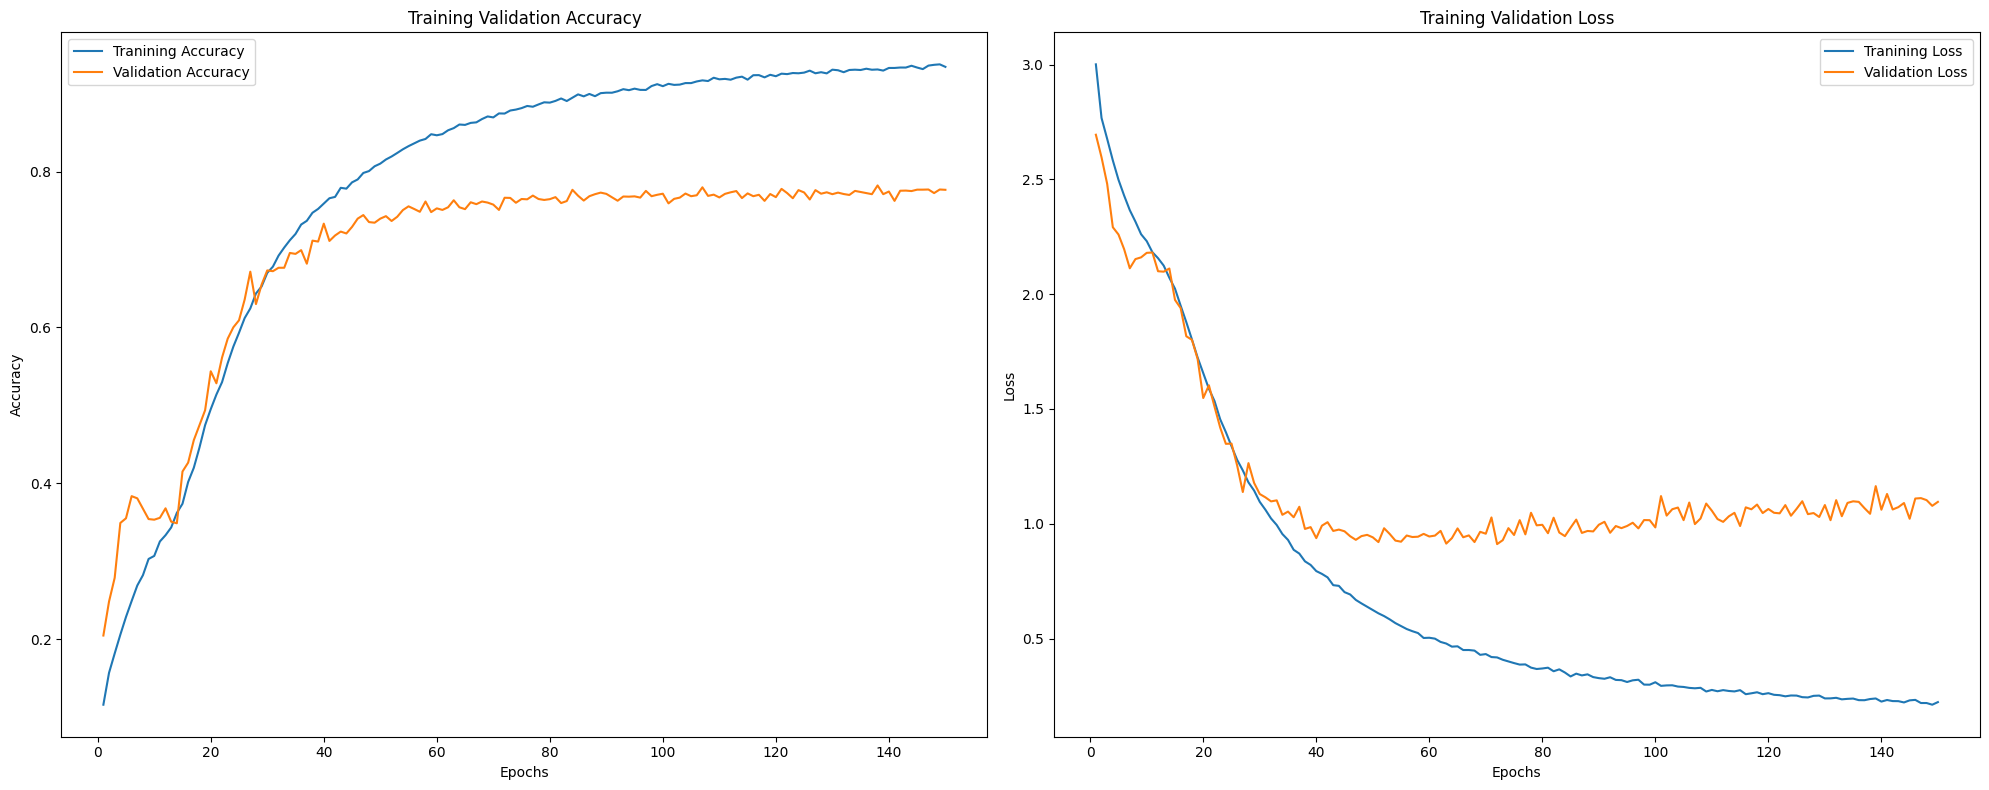

In [15]:
visualize_result(history1)

157/157 [==============================] - 4s 26ms/step - loss: 1.0714 - accuracy: 0.7764


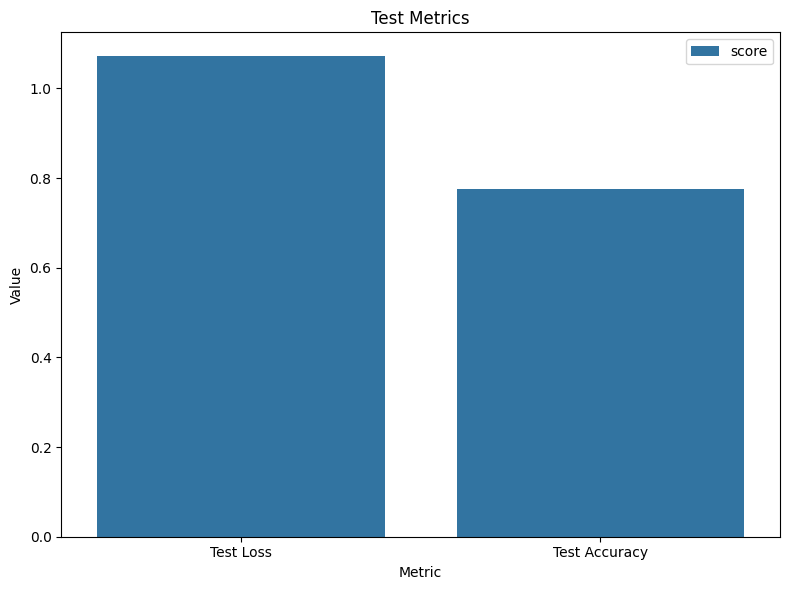

In [16]:
test_loss1, test_acc1 = visualize_test_metrics(model=model1, test_gen=test_gen)

In [17]:
g_dict = test_gen.class_indices
classes_test = list(g_dict.keys())

157/157 [==============================] - 2s 14ms/step


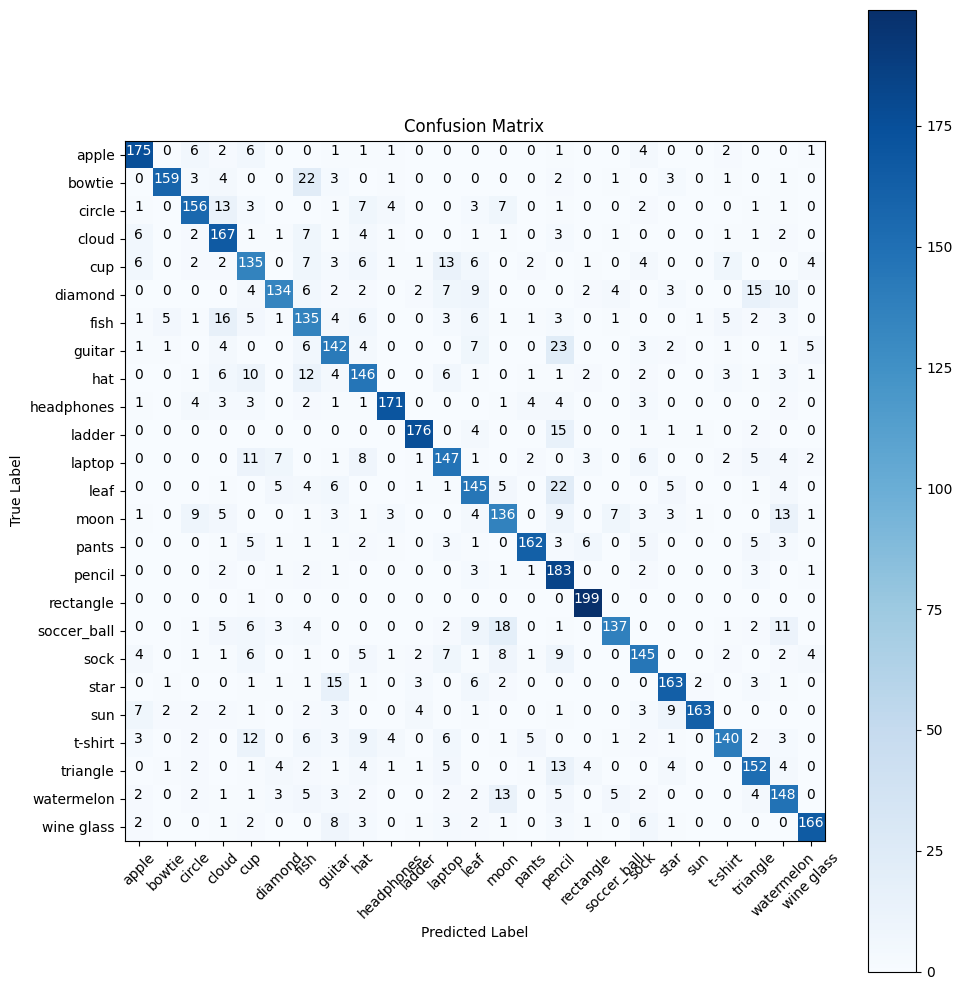

In [18]:
visualize_confusion_matrix(classes=classes_test, test_gen=test_gen, model=model1)

## TRAIN CUSTOM MODEL 2

In [19]:
model2 = custom_model2((64, 64, 3))
filepath = r"models/best_model2.h5"
epochs = 150
model2.compile(optimizer='Adam',
             loss='categorical_crossentropy', 
              metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                monitor='val_loss',
                                               save_best_only=True,
                                               save_weights_only=False)
history2 = model2.fit(x=train_gen,
         validation_data=val_gen,
         epochs=epochs,
         verbose=1,
        callbacks=[checkpoint])
model2.save(r"models/FinalModel2.h5")
model2.save_weights(r"weights/FinalWeights2.h5")
model2.summary()
with open(r"weights/model_summary2.txt", "w", encoding="utf-8") as f:
    model2.summary(print_fn=lambda x: f.write(x + "\n")) #Lưu summary
with open(r'weights/training_history2.json', 'w') as f:
    json.dump(history2.history, f) #Lưu điểm số
print("Train and save completed!!!")

Epoch 1/150
1250/1250 [==============================] - 27s 20ms/step - loss: 3.1708 - accuracy: 0.0631 - val_loss: 3.0853 - val_accuracy: 0.0806
Epoch 2/150
1250/1250 [==============================] - 25s 20ms/step - loss: 3.1004 - accuracy: 0.0771 - val_loss: 3.0062 - val_accuracy: 0.1026
Epoch 3/150
1250/1250 [==============================] - 25s 20ms/step - loss: 3.0061 - accuracy: 0.0958 - val_loss: 2.9141 - val_accuracy: 0.1298
Epoch 4/150
1250/1250 [==============================] - 25s 20ms/step - loss: 2.9050 - accuracy: 0.1148 - val_loss: 2.7701 - val_accuracy: 0.1786
Epoch 5/150
1250/1250 [==============================] - 25s 20ms/step - loss: 2.8410 - accuracy: 0.1330 - val_loss: 2.8518 - val_accuracy: 0.1388
Epoch 6/150
1250/1250 [==============================] - 25s 20ms/step - loss: 2.7788 - accuracy: 0.1542 - val_loss: 2.7164 - val_accuracy: 0.1706
Epoch 7/150
1250/1250 [==============================] - 25s 20ms/step - loss: 2.7312 - accuracy: 0.1691 - val_loss: 2

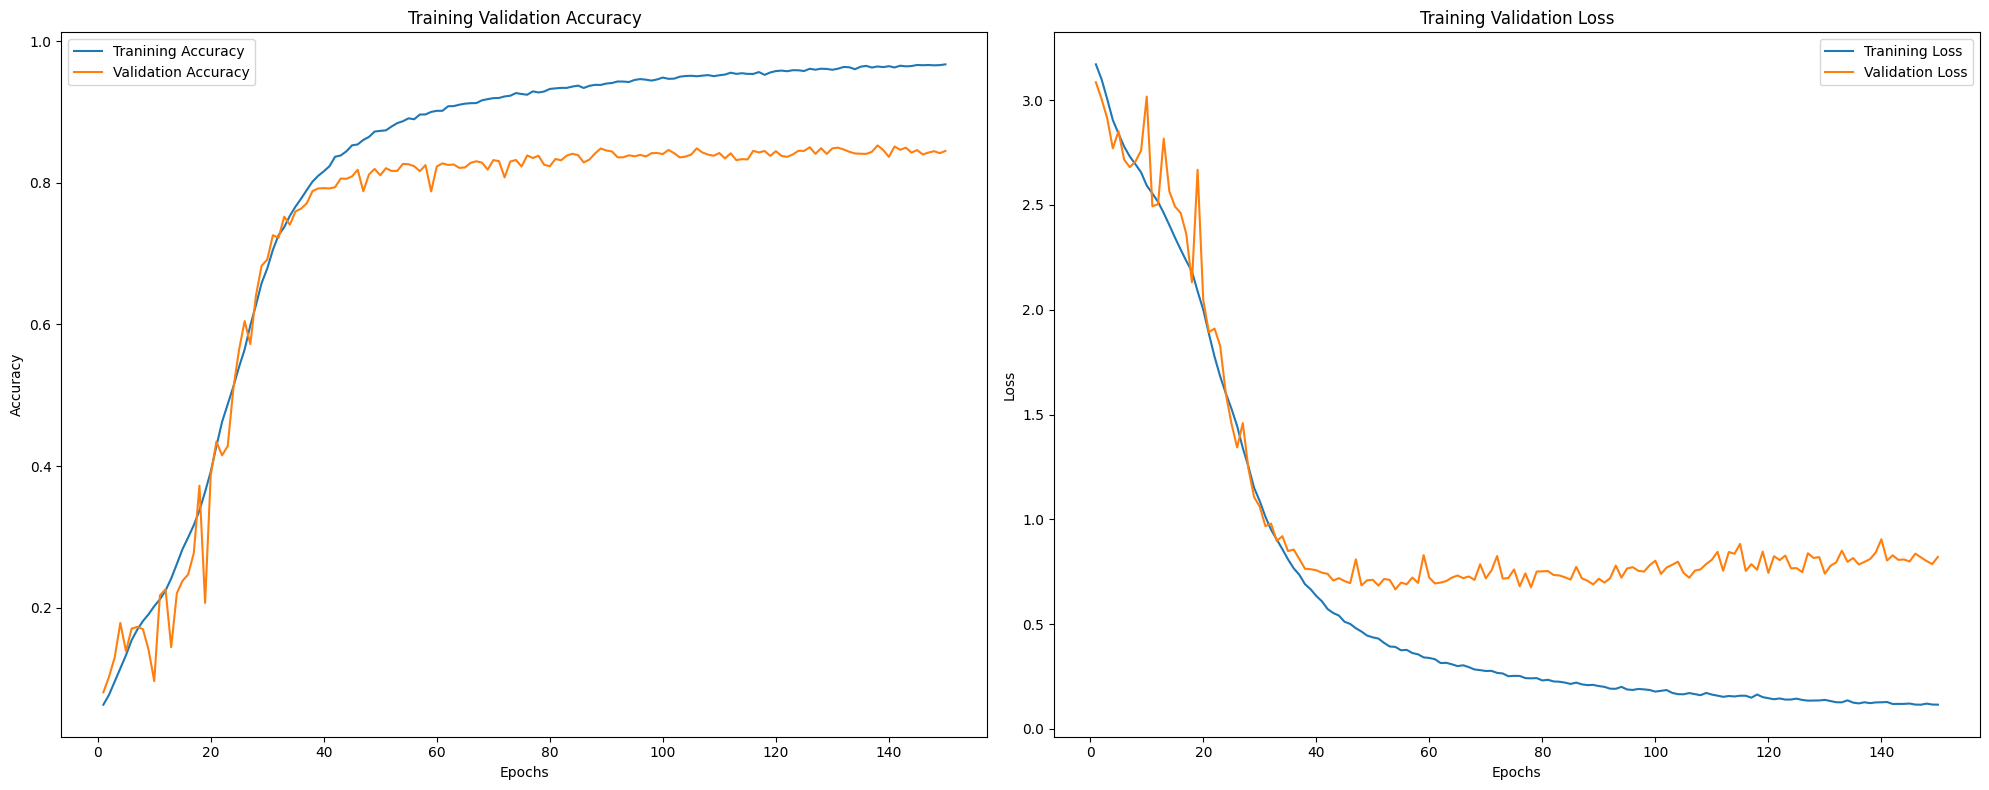

In [20]:
visualize_result(history2)

157/157 [==============================] - 3s 16ms/step - loss: 0.7834 - accuracy: 0.8584


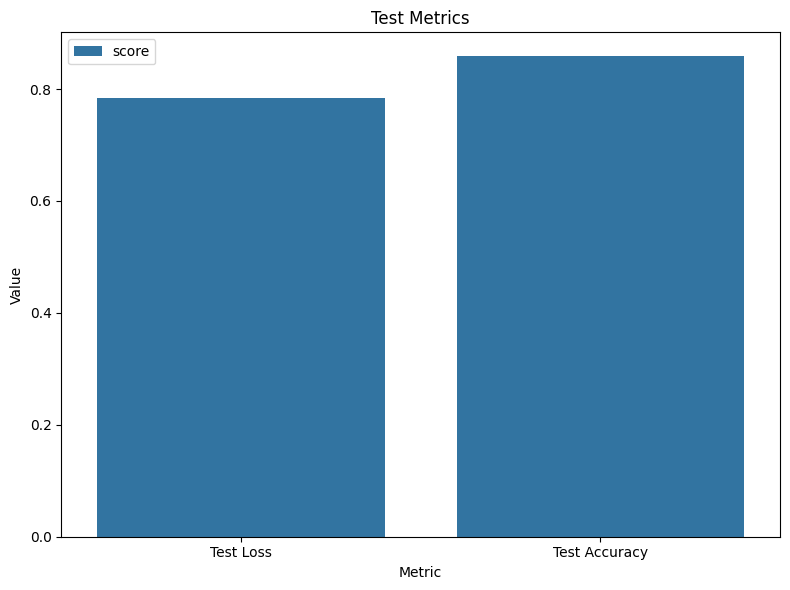

In [21]:
test_loss2, test_acc2 = visualize_test_metrics(model=model2, test_gen=test_gen)

157/157 [==============================] - 2s 15ms/step


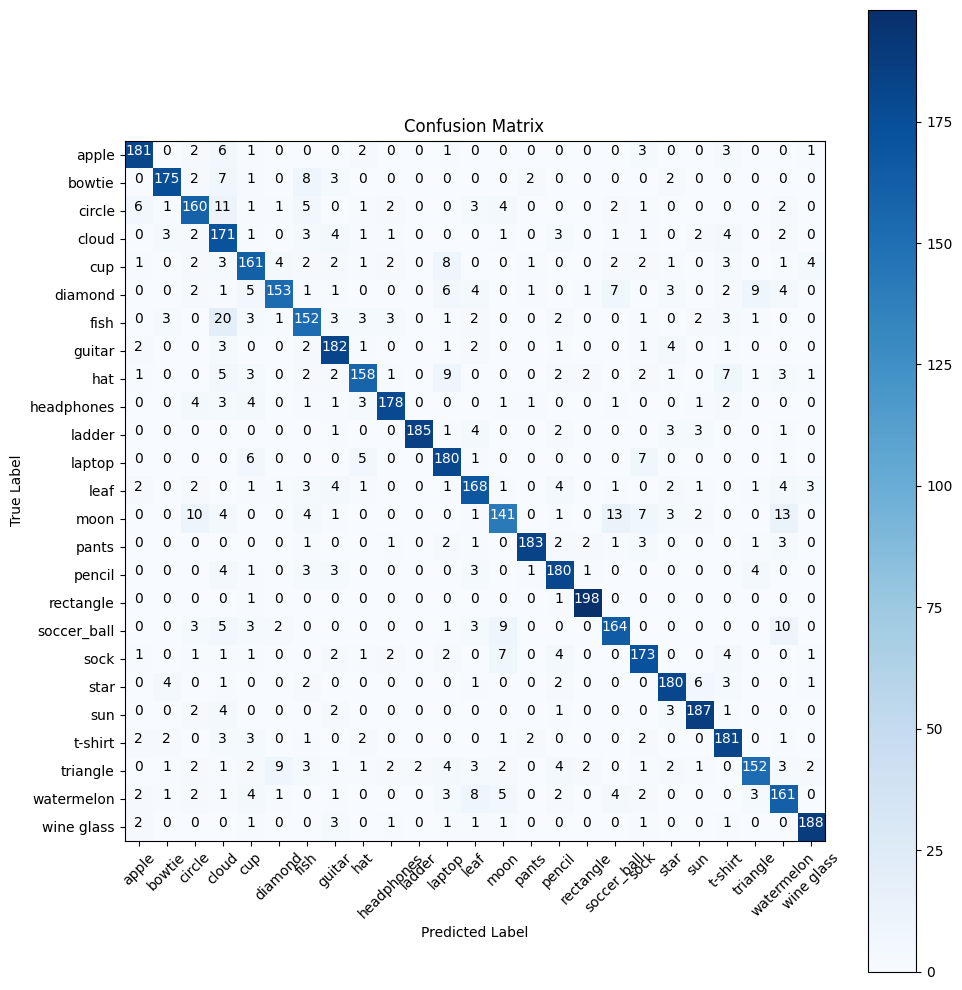

In [22]:
visualize_confusion_matrix(classes=classes_test, test_gen=test_gen, model=model2)

### COMPARE METRIC ON TEST SET

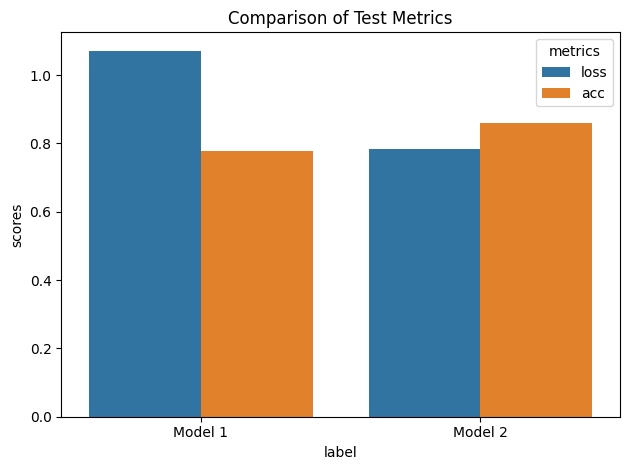

In [23]:
def compare_test_metrics(test_loss1, test_acc1, test_loss2, test_acc2):
    data = {"scores": [test_loss1, test_acc1, test_loss2, test_acc2],
           "metrics": ["loss", "acc", "loss", "acc"],
           'label': ["Model 1", "Model 1", "Model 2", "Model 2"]}
    df = pd.DataFrame(data)
    sns.barplot(data=df, x='label', y='scores', hue="metrics")
    plt.title("Comparison of Test Metrics")
    plt.tight_layout()
    plt.show()

compare_test_metrics(test_loss1, test_acc1, test_loss2, test_acc2)

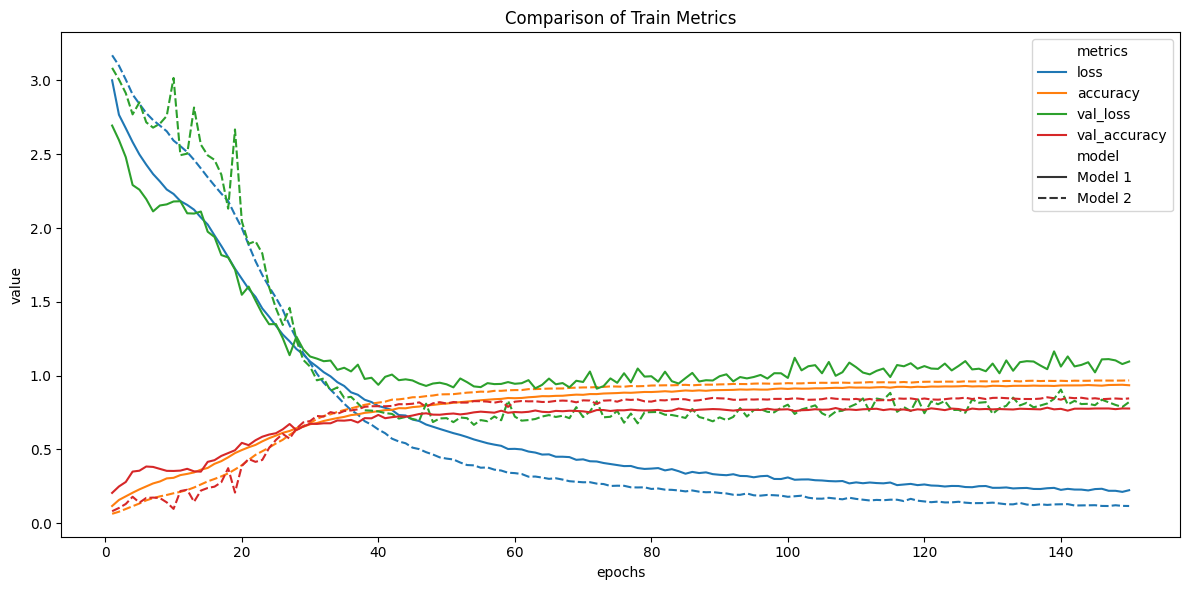

In [24]:
def read_json(path):
    with open(path, 'r') as f:
        dic = json.load(f)
    return dic
def compare_train_metrics(path1, path2):
    history_model1 = read_json(path1)
    tmp1 = len(history_model1['loss'])
    epochs1 = [i+1 for i in range(tmp1)]
    history_model1['model'] = ['Model 1' for i in range(tmp1)]
    history_model1['epochs'] = epochs1
    history_model2 = read_json(path2)
    tmp2 = len(history_model2["loss"])
    epochs2 = [i+1 for i in range(tmp2)]
    history_model2['model'] = ["Model 2" for i in range(tmp2)]
    history_model2['epochs'] = epochs2
    df1 = pd.DataFrame(history_model1)
    df2 = pd.DataFrame(history_model2)
    df = pd.concat([df1, df2], axis=0)
    df = df.melt(id_vars=['model', "epochs"], value_vars=['loss', "accuracy", "val_loss", "val_accuracy"],
                var_name="metrics",
                ignore_index=True)
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='epochs', y='value', hue='metrics', style='model')
    plt.title("Comparison of Train Metrics")
    plt.tight_layout()
    plt.show()
path1 = r'weights/training_history1.json'
path2 = r'weights/training_history2.json'
compare_train_metrics(path1, path2)

157/157 [==============================] - 2s 14ms/step - loss: 0.8763 - accuracy: 0.7808
Test on Checkpoint model: Loss 0.8762927055358887, Acc 0.7807999849319458
157/157 [==============================] - 2s 15ms/step - loss: 1.0714 - accuracy: 0.7764
Test on Final model: Loss 1.071362018585205, Acc 0.7764000296592712


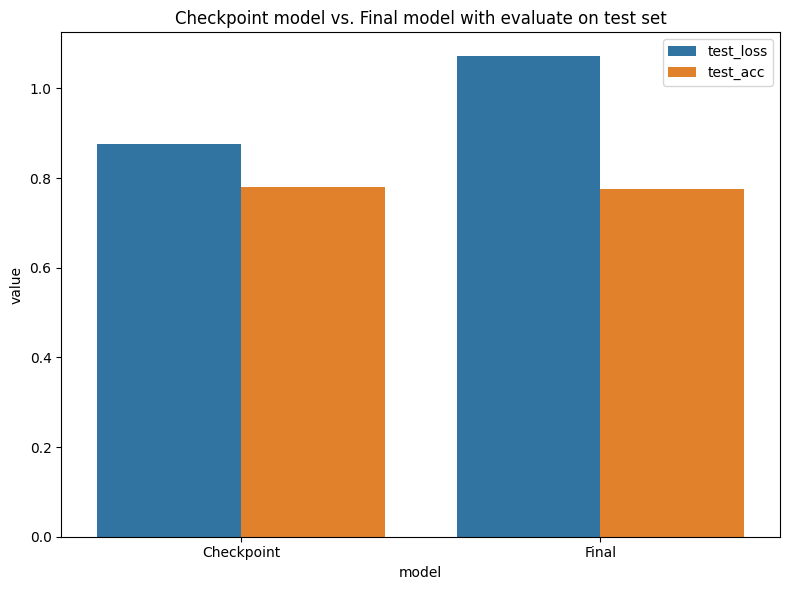

157/157 [==============================] - 3s 15ms/step - loss: 0.6386 - accuracy: 0.8322
Test on Checkpoint model: Loss 0.6385706663131714, Acc 0.8321999907493591
157/157 [==============================] - 2s 14ms/step - loss: 0.7834 - accuracy: 0.8584
Test on Final model: Loss 0.7834106087684631, Acc 0.8583999872207642


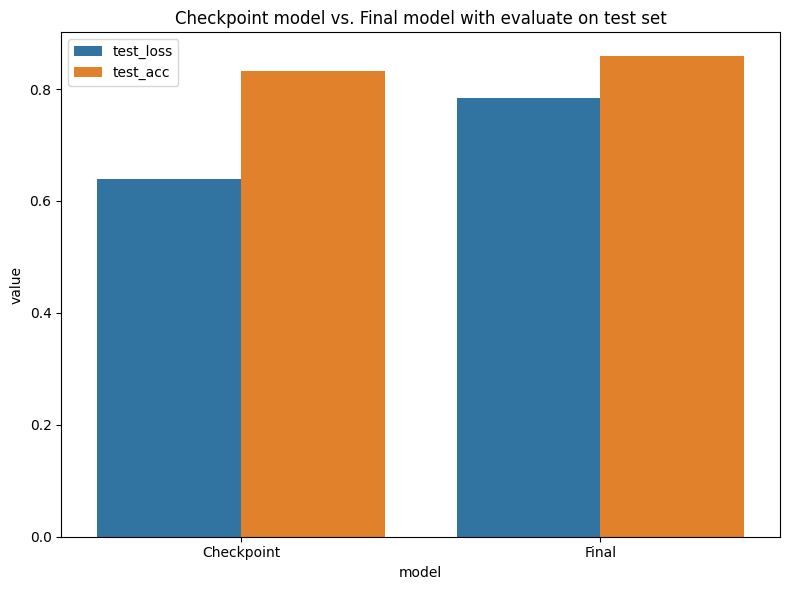

In [25]:
def compare_checkpoint_final(checkpoint_path, final_path, test_gen):
    checkpoint_model = tf.keras.models.load_model(checkpoint_path)
    final_model = tf.keras.models.load_model(final_path)
    test_loss_cb, test_acc_cb = checkpoint_model.evaluate(test_gen)
    print(f"Test on Checkpoint model: Loss {test_loss_cb}, Acc {test_acc_cb}")
    test_loss_final, test_acc_final = final_model.evaluate(test_gen)
    print(f"Test on Final model: Loss {test_loss_final}, Acc {test_acc_final}")
    df = pd.concat([pd.DataFrame({'model': ["Checkpoint" for _ in range(2)],
                                 "metrics": ["test_loss", "test_acc"],
                                 "value": [test_loss_cb, test_acc_cb]}),
                   pd.DataFrame({"model": ["Final" for _ in range(2)],
                                "metrics": ["test_loss", "test_acc"],
                                "value": [test_loss_final, test_acc_final]})], axis=0)
    plt.figure(figsize=(8,6))
    sns.barplot(data=df, x="model", y='value', hue="metrics")
    plt.title("Checkpoint model vs. Final model with evaluate on test set")
    plt.tight_layout()
    plt.legend()
    plt.show()
compare_checkpoint_final(checkpoint_path=r"models/best_model1.h5", final_path=r"models/FinalModel1.h5", test_gen=test_gen)
compare_checkpoint_final(checkpoint_path=r"models/best_model2.h5", final_path=r"models/FinalModel2.h5", test_gen=test_gen)

In [ ]:
model3 = custom_model2((64, 64, 3))
filepath = r"models/best_model3.h5"
epochs = 150
model3.compile(optimizer='Adam',
             loss='categorical_crossentropy', 
              metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                monitor='val_loss',
                                               save_best_only=True,
                                               save_weights_only=False)
history3 = model3.fit(x=train_gen,
         validation_data=val_gen,
         epochs=epochs,
         verbose=2,
        callbacks=[checkpoint])
model3.save(r"models/FinalModel3.h5")
model3.save_weights(r"weights/FinalWeights3.h5")
model3.summary()
with open(r"weights/model_summary3.txt", "w", encoding="utf-8") as f:
    model3.summary(print_fn=lambda x: f.write(x + "\n")) #Lưu summary
with open(r'weights/training_history3.json', 'w') as f:
    json.dump(history3.history, f) #Lưu điểm số
print("Train and save completed!!!")

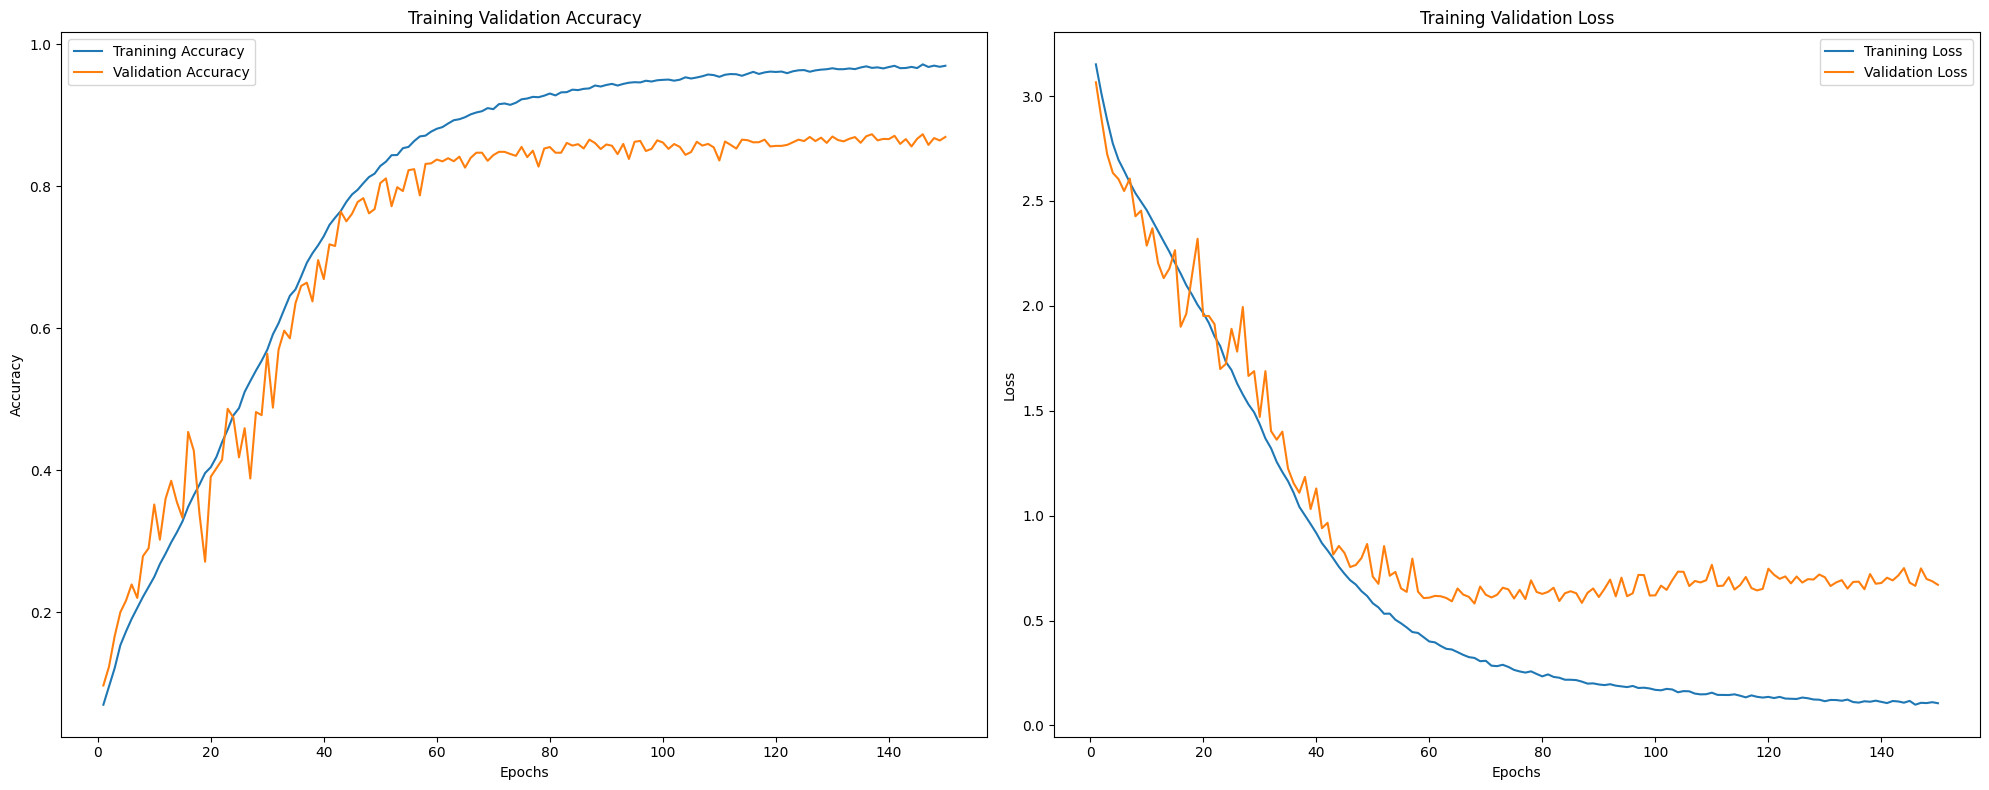

In [37]:
visualize_result(history3)

79/79 [==============================] - 6s 66ms/step - loss: 0.6567 - accuracy: 0.8322
Test on Checkpoint model: Loss 0.6567494869232178, Acc 0.8321999907493591
79/79 [==============================] - 3s 28ms/step - loss: 0.7876 - accuracy: 0.8538
Test on Final model: Loss 0.7875944972038269, Acc 0.8537999987602234


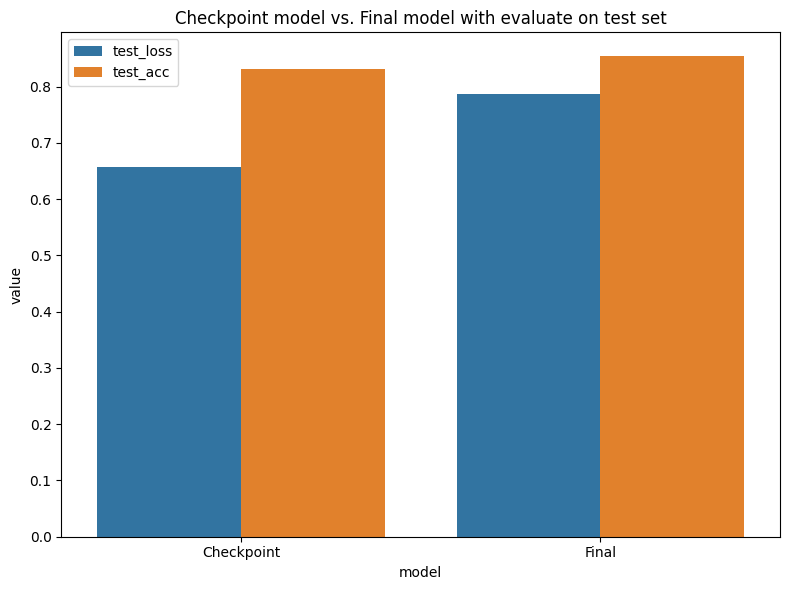

In [45]:
compare_checkpoint_final(r"models/best_model3.h5", r"models/FinalModel3.h5", test_gen=test_gen)

79/79 [==============================] - 4s 44ms/step


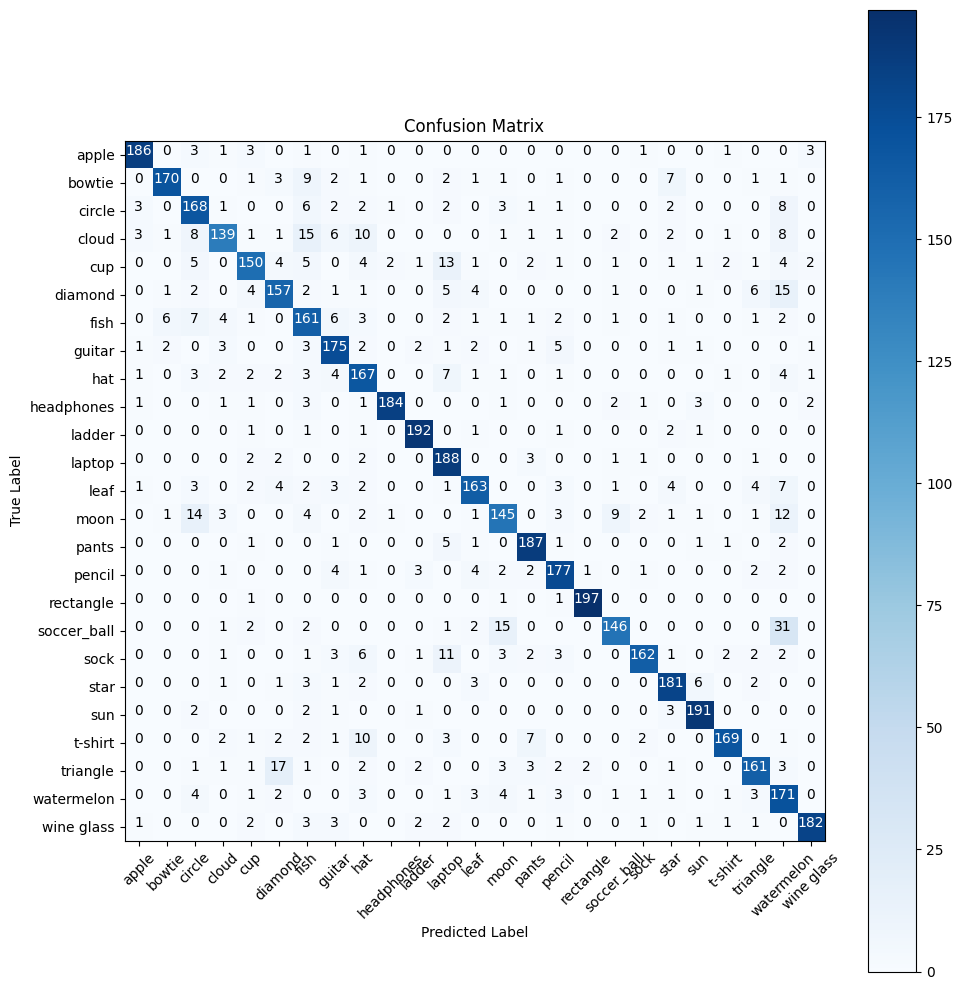

In [48]:
visualize_confusion_matrix(classes=classes_test, test_gen=test_gen, model=model3)